In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import numpy as np
import glob
import os
import torchvision.transforms as T
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

PATH="../data"
MODEL_PATH="../models"
BATCH_SIZE = 32

# My laptop is apple silicon, so I need to use mps to run the code
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# custom datasets to loading .npy files
class PhysicsDataset(Dataset):
    def __init__(self, root, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        # custom classes and load each class's files
        classes = {'no': 0, 'sphere': 1, 'vort': 2}
        for label, idx in classes.items():
            files = glob.glob(os.path.join(root, label, '*.npy'))
            for file in files:
                self.data.append(file)
                self.labels.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = np.load(self.data[idx])
        
        # convert image to RGB format(H, W, 3)
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        elif img.shape[-1] == 1:
            img = np.concatenate([img]*3, axis=-1)
        else:
            img = img.transpose(1, 2, 0)

        img = np.squeeze(img)
        img = Image.fromarray((img*255).astype(np.uint8)).convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

In [3]:
'''
I used 0.5 mean and std for normalization, but I found that loss is not decreasing, 
so I calculated the mean and std of the dataset
'''
dataset = PhysicsDataset(PATH+'/train', transform=T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
]))

loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)

print("Calculating mean and std...")

for images, _ in loader:
    mean += images.mean([0, 2, 3])
    std += images.std([0, 2, 3])

mean /= len(loader)
std /= len(loader)

print(f"Mean: {mean.tolist()}")
print(f"Std: {std.tolist()}")

Calculating mean and std...
Mean: [0.05972165986895561, 0.05972165986895561, 0.05972165986895561]
Std: [0.11680170893669128, 0.11680170893669128, 0.11680170893669128]


In [4]:
# define transformations with calculated mean and std to normalize
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [5]:
# load train and test datasets
train_dataset = PhysicsDataset(PATH+'/train', transform=transform)
test_dataset = PhysicsDataset(PATH+'/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
# define physics layer using gravitational lens equation
class PhysicsLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(512, 128)

    def forward(self, x):
        x = self.fc(x)
        beta = x[:, :64]
        theta = x[:, 64:]
        alpha = theta - beta
        return torch.cat([beta, alpha], dim=1)

In [7]:
# define pinn model
class LensPINN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.features.fc = nn.Identity()
        self.physics = PhysicsLayer()
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.physics(x)
        return self.classifier(x)

# create model
model = LensPINN().to(device)

In [8]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [9]:
train_losses, test_accuracies = [], []

# train model for 20 epochs
for epoch in range(20):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # evaluate model after each epoch and print loss and accuracy
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/20], Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.4f}')

Epoch [1/20], Loss: 0.7556, Val Accuracy: 0.8265
Epoch [2/20], Loss: 0.3819, Val Accuracy: 0.8809
Epoch [3/20], Loss: 0.2839, Val Accuracy: 0.8816
Epoch [4/20], Loss: 0.2346, Val Accuracy: 0.8972
Epoch [5/20], Loss: 0.1857, Val Accuracy: 0.9167
Epoch [6/20], Loss: 0.1524, Val Accuracy: 0.9080
Epoch [7/20], Loss: 0.1235, Val Accuracy: 0.9225
Epoch [8/20], Loss: 0.0944, Val Accuracy: 0.9237
Epoch [9/20], Loss: 0.0719, Val Accuracy: 0.9137
Epoch [10/20], Loss: 0.0589, Val Accuracy: 0.9179
Epoch [11/20], Loss: 0.0506, Val Accuracy: 0.9119
Epoch [12/20], Loss: 0.0405, Val Accuracy: 0.9137
Epoch [13/20], Loss: 0.0372, Val Accuracy: 0.9052
Epoch [14/20], Loss: 0.0367, Val Accuracy: 0.9133
Epoch [15/20], Loss: 0.0318, Val Accuracy: 0.9124
Epoch [16/20], Loss: 0.0276, Val Accuracy: 0.9092
Epoch [17/20], Loss: 0.0304, Val Accuracy: 0.9184
Epoch [18/20], Loss: 0.0252, Val Accuracy: 0.9197
Epoch [19/20], Loss: 0.0226, Val Accuracy: 0.9125
Epoch [20/20], Loss: 0.0270, Val Accuracy: 0.9151


Validation Accuracy: 0.9151
Validation ROC AUC: 0.9823


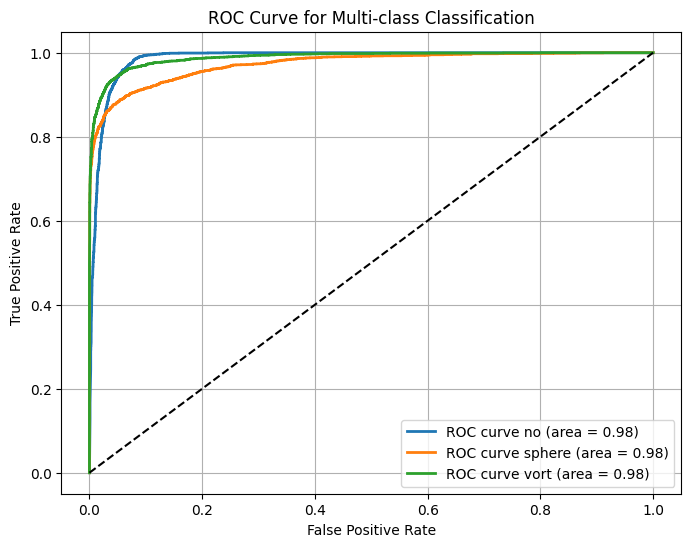

In [13]:
# plot loss and accuracy curves
model.eval()
y_true, y_scores = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)
y_pred = np.argmax(y_scores, axis=1)

acc = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(label_binarize(y_true, classes=[0, 1, 2]), y_scores, average='macro', multi_class='ovr')

print(f'Validation Accuracy: {acc:.4f}')
print(f'Validation ROC AUC: {roc_auc:.4f}')
classes = ['no', 'sphere', 'vort']
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve {class_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [19]:
torch.save(model.state_dict(), MODEL_PATH + '/pinn_model.pth')

In [ ]:
'''
model = LensPINN().to(device)
model.load_state_dict(torch.load(PATH+'/models/pinn_model.pth'))
model.eval()
'''